# **Clustering menggunakan Algoritma K-Means**

Pada clustering metode yang digunakan menggunakan K-Means. Algoritma ini umumnya bekerja sebagai berikut :


* Menentukan k sebagai jumlah cluster yang akan dibentuk
* Bangkitkan k centriod secara random
* Menghitung jarak setiap data ke centroid terdekat
* Tentukan cluster terdekat untk setiap data dengan membandingkan nilai jarak terdekat, lalu perbaharui nilai pusat clusternya.
* Ulangi sampai konvergen


In [108]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
import numpy as np 
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/ridhwanashir/ML-Clustering1/main/salju_train.csv'

# from google.colab import files
# uploaded = files.upload()

# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir("/content/drive/My Drive/Colab Notebooks/salju") 

# fileNames = os.listdir()
# print(fileNames)

In [109]:
data = pd.read_csv(url) 
data.head()

,id,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,1,01/06/2014,C4,10.4,15.5,4.8,NaN,NaN,WSW,24.0,NaN,WSW,0.0,13.0,78.0,76.0,1020.1,1018.5,NaN,NaN,13.1,15.0,Ya,Tidak
1,2,15/07/2014,C10,9.0,17.0,8.0,2.6,7.4,NaN,NaN,SW,WNW,13.0,20.0,80.0,61.0,1015.2,1014.6,7.0,5.0,11.9,15.5,Ya,Ya
2,3,16/02/2011,C46,18.2,32.0,0.0,NaN,NaN,ESE,44.0,SE,SE,15.0,26.0,62.0,42.0,NaN,NaN,NaN,NaN,23.8,29.6,Tidak,Tidak
3,4,08/08/2012,C36,7.3,24.5,0.0,8.4,10.4,SSW,54.0,N,SW,13.0,19.0,25.0,17.0,1019.2,1016.9,1.0,7.0,15.3,23.2,Tidak,Tidak
4,5,29/10/2016,C7,5.9,20.3,0.0,3.6,12.6,N,37.0,NNW,ESE,22.0,19.0,55.0,48.0,1019.7,1014.7,2.0,6.0,12.4,18.1,Tidak,Tidak


# Data Exploration

In [110]:
data.dtypes

id                            int64
Tanggal                      object
KodeLokasi                   object
SuhuMin                     float64
SuhuMax                     float64
Hujan                       float64
Penguapan                   float64
SinarMatahari               float64
ArahAnginTerkencang          object
KecepatanAnginTerkencang    float64
ArahAngin9am                 object
ArahAngin3pm                 object
KecepatanAngin9am           float64
KecepatanAngin3pm           float64
Kelembaban9am               float64
Kelembaban3pm               float64
Tekanan9am                  float64
Tekanan3pm                  float64
Awan9am                     float64
Awan3pm                     float64
Suhu9am                     float64
Suhu3pm                     float64
BersaljuHariIni              object
BersaljuBesok                object
dtype: object

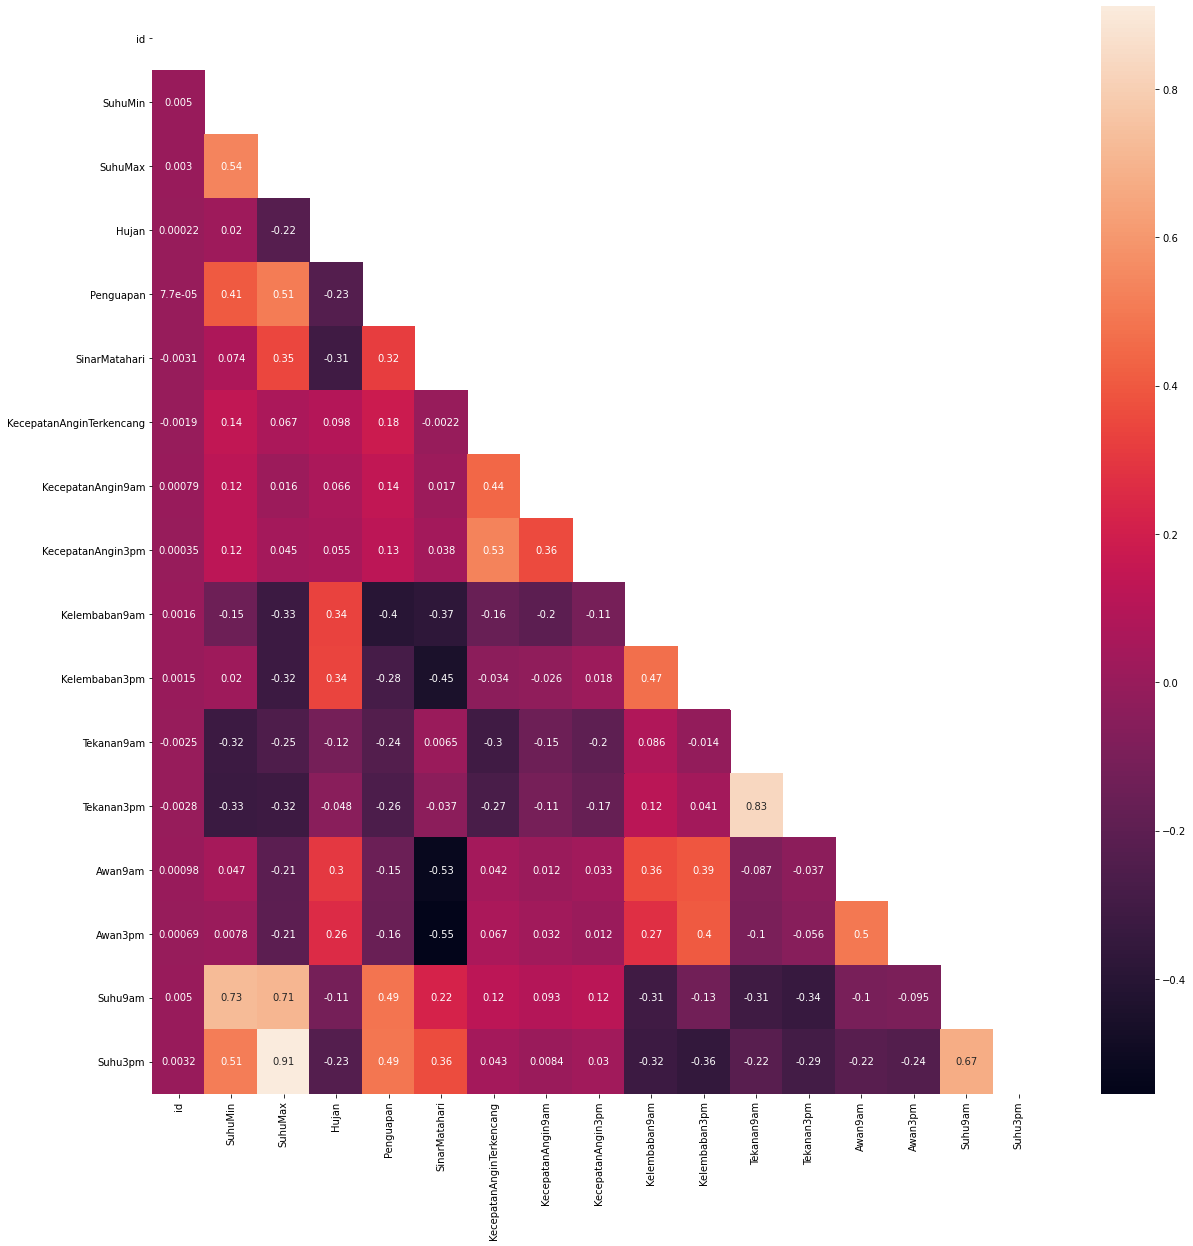

In [111]:
# Korelasi antar atribut

import seaborn as sns

plt.figure(figsize=(20,20))
cor = data.corr(method="kendall")
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask, annot=True)

# sns.pairplot(data, corner=True, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

In [112]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method="kendall")
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [119]:
corr_features = correlation(data, 0.7)
len(set(corr_features))

3

In [120]:
corr_features

{'Suhu3pm', 'Suhu9am', 'Tekanan3pm'}

Merupakan hubungan antar atribut, yang memiliki korelasi yang tinggi adalah atribut yang nilainya mendekati 1

In [121]:
#memilih kolom yang akan digunakan / feature selection

# selected_col = ['SuhuMin','SuhuMax','Hujan','Penguapan']

selected_col = corr_features
selected_col_len = len(set(corr_features))
data_baru = data[selected_col]
data_baru.to_csv('Salju_baru.csv')
data_baru.head()

,Suhu9am,Suhu3pm,Tekanan3pm
0,13.1,15.0,1018.5
1,11.9,15.5,1014.6
2,23.8,29.6,NaN
3,15.3,23.2,1016.9
4,12.4,18.1,1014.7


In [122]:
#Menghilangkan duplikat data

dups = data_baru.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))


Number of duplicate rows = 3792


In [123]:
print('Number of rows before discarding duplicates = %d' % (data_baru.shape[0]))
data = data_baru.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data.shape[0]))

Number of rows before discarding duplicates = 109095
Number of rows after discarding duplicates = 105303


In [125]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Suhu9am,104832.0,17.003466,6.507119,-7.2,12.3,16.7,21.6,40.2
Suhu3pm,103986.0,21.698877,6.941827,-5.4,16.6,21.1,26.4,46.7
Tekanan3pm,96886.0,1015.248978,7.062856,977.1,1010.4,1015.2,1020.0,1039.6


# Data Pra-Process

## Missing Value

In [126]:
#cek missing value

total=data.isnull().sum().sort_values(ascending = False)
print(total)

Tekanan3pm    8417
Suhu3pm       1317
Suhu9am        471
dtype: int64


In [127]:
#remove data null

data_baru = data.dropna(how='any',subset=selected_col)
data_baru.isnull().sum()

Suhu9am       0
Suhu3pm       0
Tekanan3pm    0
dtype: int64

**Atau bisa mengisi missing value dengan nilai mean atau median**.

Sebelum mengisi nilai missing value, dicek terlebih dahulu skewness dari data, untuk menentukan teknik pengisian missing value yang tepat. Nilai skewness normal berada pada kisaran -2 sampai 2,jika nilai skewness normal maka data null diisi dengan mean. sedangkan jika tidak normal diisi dengan median.

In [ ]:
df=['SuhuMin','SuhuMax','Hujan','Penguapan']
data[df].skew(axis=0, skipna=True)

SuhuMin      0.002305
SuhuMax      0.217030
Hujan        9.666336
Penguapan    3.916651
dtype: float64

In [ ]:
#Mengisi missing value dengan mean dan median

data['SuhuMin'].fillna(data['SuhuMin'].mean(),inplace=True)
data['SuhuMax'].fillna(data['SuhuMax'].mean(),inplace=True)
data['Hujan'].fillna(data['Hujan'].median(),inplace=True)
data['Penguapan'].fillna(data['Penguapan'].median(),inplace=True)

In [ ]:
#Checking Missing Value

total=data.isnull().sum().sort_values(ascending = False)
print(total)

Penguapan    0
Hujan        0
SuhuMax      0
SuhuMin      0
dtype: int64


## Outlier

<Figure size 500x1500 with 0 Axes>

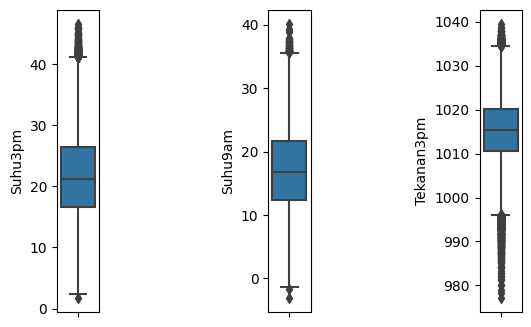

In [129]:
mpl.rcParams['figure.dpi'] = 100
plt.figure(figsize=(5,15))
f, axes = plt.subplots(1, selected_col_len)
sns.boxplot(y=data_baru["Suhu3pm"], ax=axes[0])
sns.boxplot(y=data_baru["Suhu9am"], ax=axes[1])
sns.boxplot(y=data_baru["Tekanan3pm"], ax=axes[2])


# for i in range (selected_col_len):
#   sns.boxplot(y=data[selected_col[i]], ax=axes[i])

plt.subplots_adjust(wspace=4)

In [130]:
#membuat fungsi deteksi outlier univariat

def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3-Q1
 lower_range = Q1-(1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [132]:
lowerbound,upperbound = outlier_treatment(data_baru['Suhu3pm'])
# print(lowerbound)
data_baru[(data_baru['Suhu3pm'] < lowerbound) | (data_baru['Suhu3pm'] > upperbound)].index

Int64Index([   376,    695,    986,   1135,   1423,   1469,   1481,   3293,
              4525,   4824,
            ...
            104519, 105139, 105954, 106239, 106444, 106703, 107318, 108287,
            108636, 108653],
           dtype='int64', length=220)

In [133]:
lowerbound,upperbound = outlier_treatment(data_baru['Suhu9am'])
# print(lowerbound)
data_baru[(data_baru['Suhu9am'] < lowerbound) | (data_baru['Suhu9am'] > upperbound)].index

Int64Index([  2289,   4525,   5633,  12598,  18581,  24284,  24547,  26948,
             27788,  28100,  31190,  32798,  35183,  38198,  43183,  43235,
             43456,  43917,  44291,  46822,  47235,  49546,  49611,  49895,
             50584,  50753,  51841,  51971,  52719,  54768,  56893,  58434,
             60146,  60582,  61749,  62884,  64031,  64150,  65895,  69452,
             69583,  72618,  76583,  77260,  78866,  79108,  79703,  82351,
             82430,  83195,  89506,  94872,  95091, 101117, 103517, 104938,
            105774, 107494, 108300, 108653],
           dtype='int64')

In [134]:
lowerbound,upperbound = outlier_treatment(data_baru['Tekanan3pm'])
# print(lowerbound)
data_baru[(data_baru['Tekanan3pm'] < lowerbound) | (data_baru['Tekanan3pm'] > upperbound)].index

Int64Index([    33,    448,    489,    710,    782,    870,    883,    897,
              1007,   1633,
            ...
            107600, 107771, 107867, 108245, 108320, 108700, 108766, 108829,
            108902, 109001],
           dtype='int64', length=690)

**Handle outlier**

In [135]:
data_baru2=data_baru

lowerbound,upperbound = outlier_treatment(data_baru['Suhu3pm'])
data_baru2.loc[(data_baru2['Suhu3pm'] < lowerbound) | (data_baru2['Suhu3pm'] > upperbound),'Suhu3pm']=np.NaN

lowerbound,upperbound = outlier_treatment(data_baru['Suhu9am'])
data_baru2.loc[(data_baru2['Suhu9am'] < lowerbound) | (data_baru2['Suhu9am'] > upperbound),'Suhu9am']=np.NaN

lowerbound,upperbound = outlier_treatment(data_baru['Tekanan3pm'])
data_baru2.loc[(data_baru2['Tekanan3pm'] < lowerbound) | (data_baru2['Tekanan3pm'] > upperbound),'Tekanan3pm']=np.NaN


In [136]:
data_baru2 = data_baru2.dropna()
data_baru2.isnull().sum()

Suhu9am       0
Suhu3pm       0
Tekanan3pm    0
dtype: int64

In [ ]:
#Mengisi missing value dengan mean dan median

out2['SuhuMin'].fillna(out2['SuhuMin'].mean(),inplace=True)
out2['SuhuMax'].fillna(out2['SuhuMax'].mean(),inplace=True)
out2['Hujan'].fillna(out2['Hujan'].median(),inplace=True)
out2['Penguapan'].fillna(out2['Penguapan'].median(),inplace=True)

In [ ]:
lowerbound,upperbound = outlier_treatment(out2['SuhuMin'])
out2[(out2['SuhuMin'] < lowerbound) | (out2['SuhuMin'] > upperbound)].index

Int64Index([], dtype='int64')

In [55]:
lowerbound,upperbound = outlier_treatment(out2['SuhuMax'])
out2[(out2['SuhuMax'] < lowerbound) | (out2['SuhuMax'] > upperbound)].index

NameError: ignored

<Figure size 500x1500 with 0 Axes>

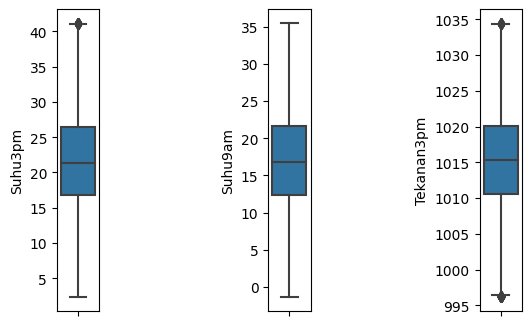

In [137]:
mpl.rcParams['figure.dpi'] = 100
plt.figure(figsize=(5,15))
f, axes = plt.subplots(1, selected_col_len)
sns.boxplot(y=data_baru2["Suhu3pm"], ax=axes[0])
sns.boxplot(y=data_baru2["Suhu9am"], ax=axes[1])
sns.boxplot(y=data_baru2["Tekanan3pm"], ax=axes[2])


# for i in range (selected_col_len):
#   sns.boxplot(y=data[selected_col[i]], ax=axes[i])

plt.subplots_adjust(wspace=4)

## Scaling

**Feature Scaling**

Bertujuan untuk membuat numerical data pada dataset memiliki rentang nilai yang sama, artinya tidak ada lagi satu variabel yang mendominasi variabel data lainnya. adapun feature scalling yang akan digunakan kali ini adalah dengan minmax normalisasi.

In [142]:
from sklearn.preprocessing import MinMaxScaler

Scaled_Data = MinMaxScaler().fit_transform(data_baru2)
Scaled_Data

array([[0.39295393, 0.32647815, 0.58333333],
       [0.3604336 , 0.33933162, 0.48177083],
       [0.45257453, 0.53727506, 0.54166667],
       ...,
       [0.37940379, 0.44987147, 0.37760417],
       [0.62601626, 0.69151671, 0.51302083],
       [0.59078591, 0.53984576, 0.2421875 ]])

## PCA

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(Scaled_Data)
data_new = pd.DataFrame(data = principalComponents, columns = ['x', 'y'])
data_new.head()

,x,y
0,-0.215624,0.032491
1,-0.178374,0.124703
2,-0.029836,-0.034020
3,-0.130560,0.091413
4,0.017208,0.076553


In [198]:
DataX = MinMaxScaler().fit_transform(data_new)
DataX

TypeError: ignored

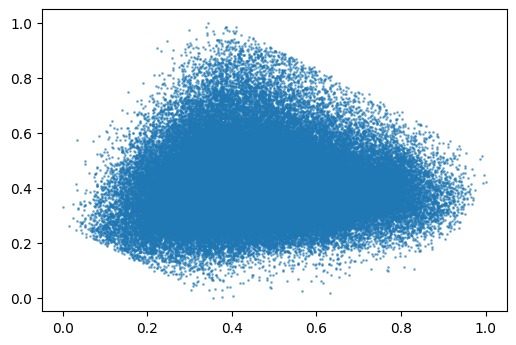

In [170]:
import matplotlib.pyplot as plt

plt.scatter(DataX[:,0], DataX[:,1], s=1, cmap ='plasma', alpha=.5)
plt.show()

In [248]:
X = data_new.copy().values
X = MinMaxScaler(feature_range=(0,10)).fit_transform(X)
X

array([[3.36091849, 4.39952402],
       [3.60355509, 5.21750586],
       [4.57106668, 3.8095172 ],
       ...,
       [4.4508117 , 5.57305488],
       [5.97910616, 3.03506744],
       [6.09963825, 5.75638704]])

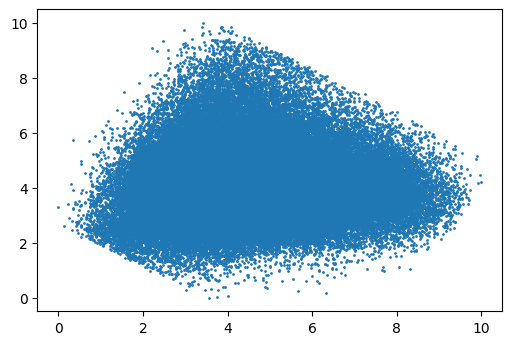

In [204]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], s=1, cmap ='plasma')
plt.show()

# Clustering

Modeling menggunakan bach

In [230]:
from copy import deepcopy
k = 3
C1 = np.random.randint(np.min(X), np.max(X), size=k) 
C2 = np.random.randint(np.min(X), np.max(X), size=k) 
C = np.array(list(zip(C1, C2)), dtype=np.float64)
C

array([[1., 6.],
       [4., 5.],
       [4., 9.]])

In [231]:
#Euclidian Distance untuk menghitung jarak data dengan centroids
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [264]:
C_old = np.zeros(C.shape)
clusters = np.zeros(len(X))
error = dist(C, C_old, None)
# print(error)

distances = dist(X[0], C)
distances
cluster = np.argmin(distances)
cluster

0

13.228756555322953


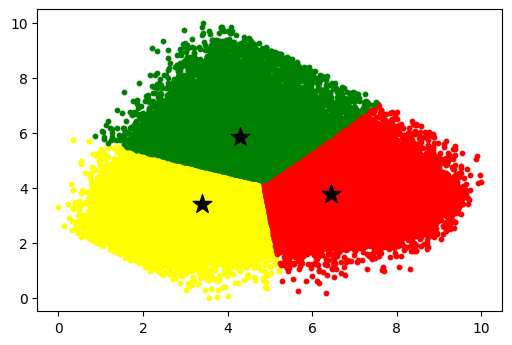

In [233]:
C_old = np.zeros(C.shape)
clusters = np.zeros(len(X))
error = dist(C, C_old, None)
print(error)

while error != 0:
    for i in range(len(X)):
        distances = dist(X[i], C) #menghitung jarak data (points) dengan masing-masing centroids
        cluster = np.argmin(distances) #menyimpan hasil cluster yang didapatkan dari nilai jarak terkecil
        clusters[i] = cluster #menyimpan hasil-hasil cluster ke array baru
    C_old = deepcopy(C) #mengcopy nilai centroids ke array C_old
 
    for i in range(k): #kode dibawah ini adalah untuk mengelompokkan data (points) yang mirip ke dalam cluster yang sama
        points = [X[j] for j in range(len(X)) if clusters[j] == i] #mengelompokkan data
        C[i] = np.mean(points, axis=0) #mengubah nilai centroid dgn rata-rata points pada cluster
    error = dist(C, C_old, None) #menghitung kembali nilai error

colors = ['yellow', 'red', 'green', 'idigo', 'violet', 'wheat']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=10, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')

PCA source : https://builtin.com/data-science/step-step-explanation-principal-component-analysis